## Fine tuning data preparation

* In the DNABERT
    * Their data for pretrain (`6_3k.txt`) didn't really have common sequence with their fine tuning data.
    * There are two fine tuning training data: `train.tsv` (21Mb) and `dev.tsv` (660K)
    * Those data are labelled (delimited by tab) into 2 classes, 0 or 1.


In [347]:
from css_utility import *
import seaborn as sns

In [3]:
# To peek how data look like:
path="../database/dnabert/examples/sample_data/ft/6/"
file_list=[os.path.join(path, file) for file in os.listdir(path)]
file_list

['../database/dnabert/examples/sample_data/ft/6/train.tsv',
 '../database/dnabert/examples/sample_data/ft/6/dev.tsv']

In [4]:
train_pre=pd.read_csv("../database/dnabert/examples/sample_data/pre/6_3k.txt", sep="\n",  \
                      header=None, names=["sequence"])  # data for pretrain
train=pd.read_csv(file_list[0], sep="\t")
dev=pd.read_csv(file_list[1], sep="\t")

In [5]:
train.head()

,sequence,label
0,CACAGC ACAGCC CAGCCA AGCCAG GCCAGC CCAGCC CAGC...,0
1,CTAATC TAATCT AATCTA ATCTAG TCTAGT CTAGTA TAGT...,1
2,GGAAGA GAAGAG AAGAGG AGAGGG GAGGGA AGGGAA GGGA...,1
3,CGAAAG GAAAGC AAAGCA AAGCAA AGCAAT GCAATC CAAT...,1
4,TGACTC GACTCC ACTCCC CTCCCA TCCCAA CCCAAA CCAA...,1


In [6]:
print("len(train_pre): ", len(train_pre))
print("len(train.tsv): ", len(train))
print("len(dev.tsv): ", len(dev))

len(train_pre):  3000
len(train.tsv):  32366
len(dev.tsv):  1000


## Read chr2 for creating the similar dataset

In [7]:
chr2_path=np.sort(all_files)[1]
chr2_path

'../database/bed/unzipped/E002_15_coreMarks_stateno.bed'

In [8]:
df=bed2df_expanded(chr2_path)

In [9]:
all_unit_css=df2unitcss(df)

In [10]:
len(all_unit_css[1])

1215996

In [11]:
with open("../database/temp_files/css_gene_lst_all", "rb") as f:
    css_gene_lst_all=pickle.load(f) # genic area only

In [12]:
len(css_gene_lst_all[0])

5255

In [13]:
len(css_gene_lst_all[0][5000])

97262

In [14]:
# length distribution first!
# then the non-genic region!

In [15]:
def flatLst(lst):
        flatten_lst=[elm for sublst in lst for elm in sublst]
        return flatten_lst

In [16]:
flatten_css_gene_lst=flatLst(css_gene_lst_all)
len(flatten_css_gene_lst)

52260

In [17]:
def len_css_gene(css_gene_lst_all,color="teal"):
    def flatLst(lst):
        flatten_lst=[elm for sublst in lst for elm in sublst]
        return flatten_lst
    flatten_css_gene_lst=flatLst(css_gene_lst_all)
#     fig=plt.figure(figsize=(6,4))    
#     plt.hist(flatten_css_gene_lst)
# #     sns.histplot(flatten_css_gene_lst, kde=False, color=color, log_scale=True, element="step", fill=False)
# #     sns.histplot(flatten_css_gene_lst, kde=False, color=color, log_scale=True)
#     plt.xlabel("Length of each element in dataset", fontsize=12)
#     plt.show()
    return flatten_css_gene_lst

In [18]:
flatten_css_gene_lst=len_css_gene(css_gene_lst_all)

In [19]:
len(flatten_css_gene_lst)

52260

In [20]:
# plt.hist(flatten_css_gene_lst)  ## too large? kernel dies everytime I run this

# Start here, now we got the new gene list

In [348]:
whole_gene_file

'../database/RefSeq/RefSeq.WholeGene.bed'

In [349]:
new_gene_lst_all=gene_removeDupl(whole_gene_file)

In [350]:
len(new_gene_lst_all)

24

In [365]:
def compNonGene2css(whole_gene_file,df):
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at "non-genic" area only.
    """
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome

    ########### new fancy gene table without overlap ###########
    new_gene_lst_all=gene_removeDupl(whole_gene_file)
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(new_gene_lst_all)
    
    css_Ngene_lst_all=[]
    print("Extracting the CSS on the intergenic region ...")
    
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=new_gene_lst_all[i] # gene df of i-th chromosome
        
        assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
        assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
        css_Ngene_lst_chr=[]        
        for j in range(len(gene_df)):
            if j==0:
                ng_start=1 # to avoid any "zero" causing problem 
                ng_end=gene_df["TxStart"].iloc[j]
#                 css_gene=css[g_start:g_end] 
                print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end))
            elif j==len(gene_df)-1: 
                ng_start=gene_df["TxEnd"].iloc[j]
                ng_end=len(css)-1
                print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end))
            else:
                ng_start=gene_df["TxEnd"].iloc[j-1]
                ng_end=gene_df["TxStart"].iloc[j]
#                 if j <=3:
                print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end))
        
            css_Ngene=css[ng_start:ng_end]
            css_Ngene_lst_chr.append(css_Ngene)
        
        css_Ngene_lst_all.append(css_Ngene_lst_chr)  
    print("Done!")
    assert len(css_Ngene_lst_all)==total_chr
    return css_Ngene_lst_all

In [366]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)


Extracting the CSS on the intergenic region ...


j: 0 | ng_start: 1 - ng_end: 11873 
j: 1 | ng_start: 29370 - ng_end: 30365 
j: 2 | ng_start: 30503 - ng_end: 34610 
j: 3 | ng_start: 36081 - ng_end: 69090 
j: 4 | ng_start: 70008 - ng_end: 134772 
j: 5 | ng_start: 140566 - ng_end: 323891 
j: 6 | ng_start: 328581 - ng_end: 367658 
j: 7 | ng_start: 368597 - ng_end: 562759 
j: 8 | ng_start: 564389 - ng_end: 567704 
j: 9 | ng_start: 567793 - ng_end: 621095 
j: 10 | ng_start: 622034 - ng_end: 661138 
j: 11 | ng_start: 665731 - ng_end: 700244 
j: 12 | ng_start: 714068 - ng_end: 752750 
j: 13 | ng_start: 755214 - ng_end: 761585 
j: 14 | ng_start: 762902 - ng_end: 762970 
j: 15 | ng_start: 794826 - ng_end: 803450 
j: 16 | ng_start: 812182 - ng_end: 852197 
j: 17 | ng_start: 855072 - ng_end: 861120 
j: 18 | ng_start: 894679 - ng_end: 895966 
j: 19 | ng_start: 901099 - ng_end: 901876 
j: 20 | ng_start: 910484 - ng_end: 910578 
j: 21 | ng_start: 917497 - ng_end: 934341 
j: 22 | ng_start: 935552 - ng_end: 948846 
j: 23 | ng_start: 949919 - ng_end:

j: 1144 | ng_start: 117602112 - ng_end: 117602948 
j: 1145 | ng_start: 117645491 - ng_end: 117653676 
j: 1146 | ng_start: 117664411 - ng_end: 117686208 
j: 1147 | ng_start: 117753582 - ng_end: 117838087 
j: 1148 | ng_start: 117863958 - ng_end: 117910084 
j: 1149 | ng_start: 118068320 - ng_end: 118139453 
j: 1150 | ng_start: 118148392 - ng_end: 118148603 
j: 1151 | ng_start: 118171011 - ng_end: 118406106 
j: 1152 | ng_start: 118472302 - ng_end: 118472371 
j: 1153 | ng_start: 118727848 - ng_end: 119425665 
j: 1154 | ng_start: 119532179 - ng_end: 119573838 
j: 1155 | ng_start: 119683295 - ng_end: 119573838 
j: 1156 | ng_start: 119818596 - ng_end: 119911398 
j: 1157 | ng_start: 119936753 - ng_end: 119957553 
j: 1158 | ng_start: 119965662 - ng_end: 120049825 
j: 1159 | ng_start: 120057681 - ng_end: 120106502 
j: 1160 | ng_start: 120115199 - ng_end: 120140324 
j: 1161 | ng_start: 120141914 - ng_end: 120161999 
j: 1162 | ng_start: 120190390 - ng_end: 120254418 
j: 1163 | ng_start: 120286849 -

j: 2143 | ng_start: 247495045 - ng_end: 247579457 
j: 2144 | ng_start: 247612406 - ng_end: 247614330 
j: 2145 | ng_start: 247615284 - ng_end: 247654369 
j: 2146 | ng_start: 247655711 - ng_end: 247670359 
j: 2147 | ng_start: 247740992 - ng_end: 247751661 
j: 2148 | ng_start: 247752615 - ng_end: 247768887 
j: 2149 | ng_start: 247769817 - ng_end: 247835419 
j: 2150 | ng_start: 247836343 - ng_end: 247875130 
j: 2151 | ng_start: 247876057 - ng_end: 247920763 
j: 2152 | ng_start: 247921708 - ng_end: 247978101 
j: 2153 | ng_start: 247979031 - ng_end: 248004229 
j: 2154 | ng_start: 248005198 - ng_end: 248020500 
j: 2155 | ng_start: 248043438 - ng_end: 248058888 
j: 2156 | ng_start: 248059833 - ng_end: 248084319 
j: 2157 | ng_start: 248085258 - ng_end: 248100330 
j: 2158 | ng_start: 248264224 - ng_end: 248285437 
j: 2159 | ng_start: 248286082 - ng_end: 248308449 
j: 2160 | ng_start: 248309388 - ng_end: 248343287 
j: 2161 | ng_start: 248344331 - ng_end: 248366369 
j: 2162 | ng_start: 248367308 -

j: 952 | ng_start: 172967478 - ng_end: 172967733 
j: 953 | ng_start: 172974710 - ng_end: 173292081 
j: 954 | ng_start: 173371183 - ng_end: 173420100 
j: 955 | ng_start: 173490351 - ng_end: 173587917 
j: 956 | ng_start: 173917620 - ng_end: 173940564 
j: 957 | ng_start: 174132737 - ng_end: 173940564 
j: 958 | ng_start: 174146764 - ng_end: 174219560 
j: 959 | ng_start: 174233718 - ng_end: 174771186 
j: 960 | ng_start: 174830430 - ng_end: 174937174 
j: 961 | ng_start: 175113365 - ng_end: 175190754 
j: 962 | ng_start: 175195370 - ng_end: 175199820 
j: 963 | ng_start: 175202268 - ng_end: 175212877 
j: 964 | ng_start: 175260443 - ng_end: 175260456 
j: 965 | ng_start: 175294303 - ng_end: 175296299 
j: 966 | ng_start: 175351816 - ng_end: 175422693 
j: 967 | ng_start: 175422800 - ng_end: 175424301 
j: 968 | ng_start: 175547627 - ng_end: 175612322 
j: 969 | ng_start: 175629200 - ng_end: 175664041 
j: 970 | ng_start: 175870107 - ng_end: 175936977 
j: 971 | ng_start: 176032934 - ng_end: 176040985 


j: 609 | ng_start: 108836993 - ng_end: 108855560 
j: 610 | ng_start: 108868951 - ng_end: 108897011 
j: 611 | ng_start: 108904108 - ng_end: 109012634 
j: 612 | ng_start: 109035364 - ng_end: 109044987 
j: 613 | ng_start: 109056419 - ng_end: 109128836 
j: 614 | ng_start: 109214014 - ng_end: 109321674 
j: 615 | ng_start: 109321744 - ng_end: 110764162 
j: 616 | ng_start: 110788806 - ng_end: 110790605 
j: 617 | ng_start: 110913016 - ng_end: 111260925 
j: 618 | ng_start: 111371206 - ng_end: 111393522 
j: 619 | ng_start: 111565294 - ng_end: 111393522 
j: 620 | ng_start: 111695364 - ng_end: 111697722 
j: 621 | ng_start: 111712215 - ng_end: 111717585 
j: 622 | ng_start: 111732735 - ng_end: 111758464 
j: 623 | ng_start: 111800116 - ng_end: 111805181 
j: 624 | ng_start: 111837073 - ng_end: 111839687 
j: 625 | ng_start: 111852152 - ng_end: 111859751 
j: 626 | ng_start: 112013074 - ng_end: 112051915 
j: 627 | ng_start: 112081658 - ng_end: 112182812 
j: 628 | ng_start: 112218408 - ng_end: 112251353 


j: 432 | ng_start: 80784401 - ng_end: 80822770 
j: 433 | ng_start: 80994626 - ng_end: 81106423 
j: 434 | ng_start: 81125482 - ng_end: 81187741 
j: 435 | ng_start: 81212171 - ng_end: 81256873 
j: 436 | ng_start: 81884910 - ng_end: 81952118 
j: 437 | ng_start: 81978685 - ng_end: 82008523 
j: 438 | ng_start: 82136271 - ng_end: 82347546 
j: 439 | ng_start: 82393082 - ng_end: 83274466 
j: 440 | ng_start: 83295149 - ng_end: 83343716 
j: 441 | ng_start: 83351378 - ng_end: 83351632 
j: 442 | ng_start: 83382328 - ng_end: 83405603 
j: 443 | ng_start: 83483126 - ng_end: 83534265 
j: 444 | ng_start: 83542590 - ng_end: 83550689 
j: 445 | ng_start: 83720010 - ng_end: 83739813 
j: 446 | ng_start: 83812433 - ng_end: 83814604 
j: 447 | ng_start: 83822069 - ng_end: 83814604 
j: 448 | ng_start: 83841122 - ng_end: 83845756 
j: 449 | ng_start: 83934094 - ng_end: 83956238 
j: 450 | ng_start: 83996971 - ng_end: 84011210 
j: 451 | ng_start: 84035911 - ng_end: 84184976 
j: 452 | ng_start: 84206067 - ng_end: 84

j: 488 | ng_start: 111756677 - ng_end: 111964132 
j: 489 | ng_start: 111966618 - ng_end: 111992124 
j: 490 | ng_start: 112018585 - ng_end: 112043201 
j: 491 | ng_start: 112181936 - ng_end: 112196884 
j: 492 | ng_start: 112228776 - ng_end: 112196884 
j: 493 | ng_start: 112258031 - ng_end: 112312406 
j: 494 | ng_start: 112630612 - ng_end: 112312406 
j: 495 | ng_start: 112824527 - ng_end: 112849390 
j: 496 | ng_start: 112930984 - ng_end: 113698015 
j: 497 | ng_start: 113832197 - ng_end: 113698015 
j: 498 | ng_start: 114109110 - ng_end: 114460458 
j: 499 | ng_start: 114516243 - ng_end: 114546526 
j: 500 | ng_start: 114598569 - ng_end: 114602884 
j: 501 | ng_start: 114632458 - ng_end: 114856607 
j: 502 | ng_start: 114880591 - ng_end: 114914192 
j: 503 | ng_start: 114961876 - ng_end: 114977821 
j: 504 | ng_start: 115008349 - ng_end: 115140429 
j: 505 | ng_start: 115152405 - ng_end: 115163893 
j: 506 | ng_start: 115177548 - ng_end: 115177618 
j: 507 | ng_start: 115249778 - ng_end: 115298150 


j: 480 | ng_start: 37362514 - ng_end: 37400906 
j: 481 | ng_start: 37449284 - ng_end: 37450696 
j: 482 | ng_start: 37467700 - ng_end: 37475123 
j: 483 | ng_start: 37504056 - ng_end: 37523140 
j: 484 | ng_start: 37523198 - ng_end: 37600283 
j: 485 | ng_start: 37665766 - ng_end: 37787306 
j: 486 | ng_start: 38122399 - ng_end: 38136226 
j: 487 | ng_start: 38607924 - ng_end: 38643701 
j: 488 | ng_start: 38670952 - ng_end: 38683116 
j: 489 | ng_start: 38998574 - ng_end: 39016556 
j: 490 | ng_start: 39055520 - ng_end: 39071838 
j: 491 | ng_start: 39082962 - ng_end: 39156746 
j: 492 | ng_start: 39197251 - ng_end: 39266776 
j: 493 | ng_start: 39282237 - ng_end: 39282473 
j: 494 | ng_start: 39290330 - ng_end: 39302875 
j: 495 | ng_start: 39693181 - ng_end: 39760158 
j: 496 | ng_start: 39872653 - ng_end: 39760158 
j: 497 | ng_start: 39902290 - ng_end: 40312083 
j: 498 | ng_start: 40323745 - ng_end: 40346162 
j: 499 | ng_start: 40347631 - ng_end: 40359372 
j: 500 | ng_start: 40555203 - ng_end: 40

j: 268 | ng_start: 42977453 - ng_end: 43152197 
j: 269 | ng_start: 43602938 - ng_end: 43622691 
j: 270 | ng_start: 43666978 - ng_end: 43670750 
j: 271 | ng_start: 43769140 - ng_end: 43798271 
j: 272 | ng_start: 43846941 - ng_end: 43906156 
j: 273 | ng_start: 43946668 - ng_end: 43906156 
j: 274 | ng_start: 43966010 - ng_end: 43966034 
j: 275 | ng_start: 44058793 - ng_end: 44068485 
j: 276 | ng_start: 44083895 - ng_end: 44084238 
j: 277 | ng_start: 44101316 - ng_end: 44102325 
j: 278 | ng_start: 44105186 - ng_end: 44111660 
j: 279 | ng_start: 44122139 - ng_end: 44143959 
j: 280 | ng_start: 44154164 - ng_end: 44154278 
j: 281 | ng_start: 44163169 - ng_end: 44178462 
j: 282 | ng_start: 44180916 - ng_end: 44183869 
j: 283 | ng_start: 44229022 - ng_end: 44240577 
j: 284 | ng_start: 44253893 - ng_end: 44256748 
j: 285 | ng_start: 44365230 - ng_end: 44421964 
j: 286 | ng_start: 44530385 - ng_end: 44552134 
j: 287 | ng_start: 44580914 - ng_end: 44605015 
j: 288 | ng_start: 44614137 - ng_end: 44

j: 234 | ng_start: 30585486 - ng_end: 30601681 
j: 235 | ng_start: 30624520 - ng_end: 30643125 
j: 236 | ng_start: 30670352 - ng_end: 30689059 
j: 237 | ng_start: 30706533 - ng_end: 30853317 
j: 238 | ng_start: 30891231 - ng_end: 30853317 
j: 239 | ng_start: 31031277 - ng_end: 31497267 
j: 240 | ng_start: 32600770 - ng_end: 31497267 
j: 241 | ng_start: 32618507 - ng_end: 31497267 
j: 242 | ng_start: 32622558 - ng_end: 33228343 
j: 243 | ng_start: 33330664 - ng_end: 33342684 
j: 244 | ng_start: 33370703 - ng_end: 33405271 
j: 245 | ng_start: 33424646 - ng_end: 33448847 
j: 246 | ng_start: 33457624 - ng_end: 34641438 
j: 247 | ng_start: 34722316 - ng_end: 35092974 
j: 248 | ng_start: 35652181 - ng_end: 36641841 
j: 249 | ng_start: 36793643 - ng_end: 36979470 
j: 250 | ng_start: 37258543 - ng_end: 37263981 
j: 251 | ng_start: 37351431 - ng_end: 37373923 
j: 252 | ng_start: 37378904 - ng_end: 37553268 
j: 253 | ng_start: 37557539 - ng_end: 37575096 
j: 254 | ng_start: 37591011 - ng_end: 37

j: 275 | ng_start: 67781179 - ng_end: 67784943 
j: 276 | ng_start: 67786625 - ng_end: 67792928 
j: 277 | ng_start: 67794189 - ng_end: 67926760 
j: 278 | ng_start: 67970293 - ng_end: 68415307 
j: 279 | ng_start: 68415388 - ng_end: 68427783 
j: 280 | ng_start: 68455368 - ng_end: 68726540 
j: 281 | ng_start: 68748376 - ng_end: 69002238 
j: 282 | ng_start: 69002321 - ng_end: 69065565 
j: 283 | ng_start: 69147854 - ng_end: 69174213 
j: 284 | ng_start: 69181041 - ng_end: 69199479 
j: 285 | ng_start: 69202204 - ng_end: 69204537 
j: 286 | ng_start: 69262630 - ng_end: 69381980 
j: 287 | ng_start: 69425109 - ng_end: 69651360 
j: 288 | ng_start: 69664949 - ng_end: 69746916 
j: 289 | ng_start: 69757784 - ng_end: 70175706 
j: 290 | ng_start: 70178815 - ng_end: 70364017 
j: 291 | ng_start: 70374924 - ng_end: 70427648 
j: 292 | ng_start: 70428899 - ng_end: 70432003 
j: 293 | ng_start: 70490211 - ng_end: 70856804 
j: 294 | ng_start: 70914951 - ng_end: 70917782 
j: 295 | ng_start: 70920000 - ng_end: 70

j: 317 | ng_start: 57360487 - ng_end: 58117198 
j: 318 | ng_start: 58121034 - ng_end: 59064238 
j: 319 | ng_start: 59064319 - ng_end: 59951277 
j: 320 | ng_start: 60027694 - ng_end: 60028861 
j: 321 | ng_start: 60049019 - ng_end: 60094738 
j: 322 | ng_start: 60130513 - ng_end: 60144902 
j: 323 | ng_start: 60158990 - ng_end: 60272903 
j: 324 | ng_start: 60591197 - ng_end: 60759277 
j: 325 | ng_start: 60761377 - ng_end: 60933722 
j: 326 | ng_start: 60936224 - ng_end: 60936347 
j: 327 | ng_start: 61122352 - ng_end: 60936347 
j: 328 | ng_start: 61122661 - ng_end: 61410521 
j: 329 | ng_start: 61469649 - ng_end: 61496747 
j: 330 | ng_start: 61513203 - ng_end: 61548505 
j: 331 | ng_start: 61666414 - ng_end: 61717974 
j: 332 | ng_start: 61720671 - ng_end: 61786055 
j: 333 | ng_start: 62493284 - ng_end: 62538088 
j: 334 | ng_start: 62554610 - ng_end: 62629197 
j: 335 | ng_start: 62760736 - ng_end: 62629197 
j: 336 | ng_start: 62761198 - ng_end: 62776032 
j: 337 | ng_start: 62786175 - ng_end: 63

j: 361 | ng_start: 31531175 - ng_end: 31531275 
j: 362 | ng_start: 31806073 - ng_end: 31806339 
j: 363 | ng_start: 31839509 - ng_end: 31806339 
j: 364 | ng_start: 31908587 - ng_end: 32057524 
j: 365 | ng_start: 32062864 - ng_end: 32112476 
j: 366 | ng_start: 32127272 - ng_end: 32165287 
j: 367 | ng_start: 32165458 - ng_end: 32409321 
j: 368 | ng_start: 32461003 - ng_end: 32409321 
j: 369 | ng_start: 32480315 - ng_end: 32605312 
j: 370 | ng_start: 32816204 - ng_end: 32851480 
j: 371 | ng_start: 32879669 - ng_end: 32914723 
j: 372 | ng_start: 33001814 - ng_end: 33037409 
j: 373 | ng_start: 33055128 - ng_end: 33060962 
j: 374 | ng_start: 33095109 - ng_end: 33097695 
j: 375 | ng_start: 33101000 - ng_end: 33106129 
j: 376 | ng_start: 33183037 - ng_end: 33183202 
j: 377 | ng_start: 33213142 - ng_end: 33278217 
j: 378 | ng_start: 33378568 - ng_end: 33563876 
j: 379 | ng_start: 33695646 - ng_end: 33719653 
j: 380 | ng_start: 33722286 - ng_end: 33724555 
j: 381 | ng_start: 33744498 - ng_end: 33

j: 1224 | ng_start: 118927957 - ng_end: 118938462 
j: 1225 | ng_start: 118952688 - ng_end: 118955586 
j: 1226 | ng_start: 118964259 - ng_end: 118964584 
j: 1227 | ng_start: 118966177 - ng_end: 118967212 
j: 1228 | ng_start: 118972785 - ng_end: 118978059 
j: 1229 | ng_start: 118987834 - ng_end: 118992232 
j: 1230 | ng_start: 119005765 - ng_end: 119019749 
j: 1231 | ng_start: 119033374 - ng_end: 119039042 
j: 1232 | ng_start: 119054726 - ng_end: 119056165 
j: 1233 | ng_start: 119060932 - ng_end: 119060962 
j: 1234 | ng_start: 119066584 - ng_end: 119076985 
j: 1235 | ng_start: 119178859 - ng_end: 119179233 
j: 1236 | ng_start: 119187840 - ng_end: 119205209 
j: 1237 | ng_start: 119208024 - ng_end: 119209643 
j: 1238 | ng_start: 119217383 - ng_end: 119225924 
j: 1239 | ng_start: 119252436 - ng_end: 119252487 
j: 1240 | ng_start: 119369944 - ng_end: 119508807 
j: 1241 | ng_start: 119599435 - ng_end: 119600292 
j: 1242 | ng_start: 119610333 - ng_end: 119981993 
j: 1243 | ng_start: 120008863 -

j: 995 | ng_start: 121792012 - ng_end: 121837885 
j: 996 | ng_start: 121862155 - ng_end: 121866899 
j: 997 | ng_start: 122018920 - ng_end: 122034433 
j: 998 | ng_start: 122034505 - ng_end: 122064454 
j: 999 | ng_start: 122079946 - ng_end: 122089292 
j: 1000 | ng_start: 122107560 - ng_end: 122150657 
j: 1001 | ng_start: 122231594 - ng_end: 122233172 
j: 1002 | ng_start: 122241390 - ng_end: 122242637 
j: 1003 | ng_start: 122270562 - ng_end: 122277432 
j: 1004 | ng_start: 122326517 - ng_end: 122326636 
j: 1005 | ng_start: 122355771 - ng_end: 122356462 
j: 1006 | ng_start: 122441832 - ng_end: 122459791 
j: 1007 | ng_start: 122499950 - ng_end: 122516633 
j: 1008 | ng_start: 122631894 - ng_end: 122652265 
j: 1009 | ng_start: 122688018 - ng_end: 122688227 
j: 1010 | ng_start: 122692084 - ng_end: 122692208 
j: 1011 | ng_start: 122712081 - ng_end: 122692208 
j: 1012 | ng_start: 122713339 - ng_end: 122716093 
j: 1013 | ng_start: 122751068 - ng_end: 122755980 
j: 1014 | ng_start: 122907116 - ng_e

j: 166 | ng_start: 34931468 - ng_end: 34985134 
j: 167 | ng_start: 35008943 - ng_end: 35030617 
j: 168 | ng_start: 35099366 - ng_end: 35179587 
j: 169 | ng_start: 35184029 - ng_end: 35221936 
j: 170 | ng_start: 35344853 - ng_end: 35409127 
j: 171 | ng_start: 35409702 - ng_end: 35452103 
j: 172 | ng_start: 35498773 - ng_end: 35514112 
j: 173 | ng_start: 35552589 - ng_end: 35514112 
j: 174 | ng_start: 35582336 - ng_end: 35514112 
j: 175 | ng_start: 35591749 - ng_end: 35514112 
j: 176 | ng_start: 35743284 - ng_end: 35747763 
j: 177 | ng_start: 35786685 - ng_end: 35870715 
j: 178 | ng_start: 35873960 - ng_end: 36003247 
j: 179 | ng_start: 36006260 - ng_end: 36007557 
j: 180 | ng_start: 36278432 - ng_end: 36295596 
j: 181 | ng_start: 36341169 - ng_end: 36539632 
j: 182 | ng_start: 36645857 - ng_end: 36767763 
j: 183 | ng_start: 36789882 - ng_end: 36942493 
j: 184 | ng_start: 36982990 - ng_end: 36985603 
j: 185 | ng_start: 36989430 - ng_end: 36985603 
j: 186 | ng_start: 36992221 - ng_end: 37

j: 430 | ng_start: 65670378 - ng_end: 65673824 
j: 431 | ng_start: 65715410 - ng_end: 65737997 
j: 432 | ng_start: 65810035 - ng_end: 65822826 
j: 433 | ng_start: 65870693 - ng_end: 65871095 
j: 434 | ng_start: 65903627 - ng_end: 65903742 
j: 435 | ng_start: 65953256 - ng_end: 65903742 
j: 436 | ng_start: 66084631 - ng_end: 66161796 
j: 437 | ng_start: 66184329 - ng_end: 66187633 
j: 438 | ng_start: 66546075 - ng_end: 66585632 
j: 439 | ng_start: 66626236 - ng_end: 66629007 
j: 440 | ng_start: 66649054 - ng_end: 66679210 
j: 441 | ng_start: 66790146 - ng_end: 66791652 
j: 442 | ng_start: 66797193 - ng_end: 66797420 
j: 443 | ng_start: 66857835 - ng_end: 66797420 
j: 444 | ng_start: 66858317 - ng_end: 66874527 
j: 445 | ng_start: 66978136 - ng_end: 66994673 
j: 446 | ng_start: 67074337 - ng_end: 67358194 
j: 447 | ng_start: 67487533 - ng_end: 67493012 
j: 448 | ng_start: 67547536 - ng_end: 67493012 
j: 449 | ng_start: 67794142 - ng_end: 67493012 
j: 450 | ng_start: 67814182 - ng_end: 67

j: 676 | ng_start: 67861971 - ng_end: 67862059 
j: 677 | ng_start: 67881361 - ng_end: 67862059 
j: 678 | ng_start: 67905219 - ng_end: 67906925 
j: 679 | ng_start: 67918417 - ng_end: 67918780 
j: 680 | ng_start: 67920271 - ng_end: 67927174 
j: 681 | ng_start: 67965778 - ng_end: 67968406 
j: 682 | ng_start: 67970780 - ng_end: 67973786 
j: 683 | ng_start: 68002597 - ng_end: 68009565 
j: 684 | ng_start: 68014452 - ng_end: 68021292 
j: 685 | ng_start: 68033421 - ng_end: 68047338 
j: 686 | ng_start: 68049814 - ng_end: 68055176 
j: 687 | ng_start: 68113226 - ng_end: 68119268 
j: 688 | ng_start: 68270136 - ng_end: 68279246 
j: 689 | ng_start: 68294961 - ng_end: 68298418 
j: 690 | ng_start: 68344868 - ng_end: 68344876 
j: 691 | ng_start: 68391169 - ng_end: 68392229 
j: 692 | ng_start: 68482409 - ng_end: 68573115 
j: 693 | ng_start: 68609975 - ng_end: 68678738 
j: 694 | ng_start: 68732970 - ng_end: 68771192 
j: 695 | ng_start: 68869445 - ng_end: 68877508 
j: 696 | ng_start: 69119085 - ng_end: 69

j: 866 | ng_start: 54560007 - ng_end: 54671059 
j: 867 | ng_start: 54672951 - ng_end: 54869273 
j: 868 | ng_start: 54911256 - ng_end: 54911459 
j: 869 | ng_start: 54946036 - ng_end: 54961462 
j: 870 | ng_start: 54962274 - ng_end: 54965269 
j: 871 | ng_start: 54991409 - ng_end: 55015560 
j: 872 | ng_start: 55038411 - ng_end: 55055467 
j: 873 | ng_start: 55084129 - ng_end: 55122838 
j: 874 | ng_start: 55124156 - ng_end: 55162552 
j: 875 | ng_start: 55198710 - ng_end: 55333930 
j: 876 | ng_start: 55757299 - ng_end: 55821841 
j: 877 | ng_start: 55822690 - ng_end: 55916286 
j: 878 | ng_start: 55927433 - ng_end: 55938603 
j: 879 | ng_start: 56032684 - ng_end: 56048909 
j: 880 | ng_start: 56065615 - ng_end: 56078279 
j: 881 | ng_start: 56084707 - ng_end: 56154251 
j: 882 | ng_start: 56160565 - ng_end: 56160779 
j: 883 | ng_start: 56167618 - ng_end: 56232514 
j: 884 | ng_start: 56233447 - ng_end: 56234319 
j: 885 | ng_start: 56236480 - ng_end: 56247016 
j: 886 | ng_start: 56247940 - ng_end: 56

j: 206 | ng_start: 7683196 - ng_end: 7684410 
j: 207 | ng_start: 7694439 - ng_end: 7694670 
j: 208 | ng_start: 7697898 - ng_end: 7694670 
j: 209 | ng_start: 7698634 - ng_end: 7701986 
j: 210 | ng_start: 7712760 - ng_end: 7733971 
j: 211 | ng_start: 7735340 - ng_end: 7741942 
j: 212 | ng_start: 7744719 - ng_end: 7745706 
j: 213 | ng_start: 7747748 - ng_end: 7753642 
j: 214 | ng_start: 7767032 - ng_end: 7793842 
j: 215 | ng_start: 7797057 - ng_end: 7804880 
j: 216 | ng_start: 7812464 - ng_end: 7828034 
j: 217 | ng_start: 7834491 - ng_end: 7852369 
j: 218 | ng_start: 7855898 - ng_end: 7895160 
j: 219 | ng_start: 7929862 - ng_end: 7933604 
j: 220 | ng_start: 7939326 - ng_end: 7943516 
j: 221 | ng_start: 7945117 - ng_end: 7953389 
j: 222 | ng_start: 7966908 - ng_end: 7968664 
j: 223 | ng_start: 7979368 - ng_end: 7981031 
j: 224 | ng_start: 7983980 - ng_end: 7985193 
j: 225 | ng_start: 7988136 - ng_end: 7989380 
j: 226 | ng_start: 7991051 - ng_end: 7991602 
j: 227 | ng_start: 8008708 - ng_en

j: 1346 | ng_start: 54567207 - ng_end: 54573200 
j: 1347 | ng_start: 54584634 - ng_end: 54597932 
j: 1348 | ng_start: 54605994 - ng_end: 54606159 
j: 1349 | ng_start: 54610281 - ng_end: 54610319 
j: 1350 | ng_start: 54635150 - ng_end: 54641435 
j: 1351 | ng_start: 54663481 - ng_end: 54663832 
j: 1352 | ng_start: 54676944 - ng_end: 54677105 
j: 1353 | ng_start: 54693733 - ng_end: 54694118 
j: 1354 | ng_start: 54698394 - ng_end: 54704725 
j: 1355 | ng_start: 54711515 - ng_end: 54720146 
j: 1356 | ng_start: 54746711 - ng_end: 54754268 
j: 1357 | ng_start: 54761171 - ng_end: 54777674 
j: 1358 | ng_start: 54785033 - ng_end: 54785963 
j: 1359 | ng_start: 54786035 - ng_end: 54799849 
j: 1360 | ng_start: 54804265 - ng_end: 54818352 
j: 1361 | ng_start: 54824409 - ng_end: 54844455 
j: 1362 | ng_start: 54850440 - ng_end: 54865232 
j: 1363 | ng_start: 54882163 - ng_end: 54926604 
j: 1364 | ng_start: 54947899 - ng_end: 54955993 
j: 1365 | ng_start: 54960216 - ng_end: 54960339 
j: 1366 | ng_start: 

j: 78 | ng_start: 31803076 - ng_end: 31812645 
j: 79 | ng_start: 31813098 - ng_end: 31852363 
j: 80 | ng_start: 31852636 - ng_end: 31859508 
j: 81 | ng_start: 31859667 - ng_end: 31863781 
j: 82 | ng_start: 31864275 - ng_end: 31869173 
j: 83 | ng_start: 31869428 - ng_end: 31874189 
j: 84 | ng_start: 31874408 - ng_end: 31913853 
j: 85 | ng_start: 31914183 - ng_end: 31933416 
j: 86 | ng_start: 31933608 - ng_end: 31962423 
j: 87 | ng_start: 31962716 - ng_end: 31964758 
j: 88 | ng_start: 31965374 - ng_end: 31971004 
j: 89 | ng_start: 31971193 - ng_end: 31973439 
j: 90 | ng_start: 31973586 - ng_end: 31986004 
j: 91 | ng_start: 31986223 - ng_end: 31988773 
j: 92 | ng_start: 31988944 - ng_end: 31992945 
j: 93 | ng_start: 31993169 - ng_end: 32007582 
j: 94 | ng_start: 32007780 - ng_end: 32015182 
j: 95 | ng_start: 32015455 - ng_end: 32090842 
j: 96 | ng_start: 32091095 - ng_end: 32119268 
j: 97 | ng_start: 32119520 - ng_end: 32127456 
j: 98 | ng_start: 32127696 - ng_end: 32185014 
j: 99 | ng_st

j: 228 | ng_start: 47781655 - ng_end: 47834249 
j: 229 | ng_start: 47863394 - ng_end: 47863733 
j: 230 | ng_start: 47869126 - ng_end: 47915698 
j: 231 | ng_start: 47931025 - ng_end: 47967366 
j: 232 | ng_start: 47980068 - ng_end: 47986602 
j: 233 | ng_start: 47991995 - ng_end: 48045655 
j: 234 | ng_start: 48056199 - ng_end: 48114751 
j: 235 | ng_start: 48126879 - ng_end: 48160984 
j: 236 | ng_start: 48165614 - ng_end: 48205862 
j: 237 | ng_start: 48216188 - ng_end: 48242956 
j: 238 | ng_start: 48252785 - ng_end: 48261523 
j: 239 | ng_start: 48271355 - ng_end: 48316919 
j: 240 | ng_start: 48328644 - ng_end: 48334408 
j: 241 | ng_start: 48344752 - ng_end: 48367346 
j: 242 | ng_start: 48379202 - ng_end: 48380163 
j: 243 | ng_start: 48387104 - ng_end: 48398074 
j: 244 | ng_start: 48420997 - ng_end: 48432740 
j: 245 | ng_start: 48439553 - ng_end: 48455879 
j: 246 | ng_start: 48463582 - ng_end: 48542185 
j: 247 | ng_start: 48549817 - ng_end: 48553944 
j: 248 | ng_start: 48567406 - ng_end: 48

j: 869 | ng_start: 152990201 - ng_end: 152990322 
j: 870 | ng_start: 153010216 - ng_end: 153029650 
j: 871 | ng_start: 153044801 - ng_end: 153046455 
j: 872 | ng_start: 153051187 - ng_end: 153051220 
j: 873 | ng_start: 153063967 - ng_end: 153067620 
j: 874 | ng_start: 153096022 - ng_end: 153126968 
j: 875 | ng_start: 153151628 - ng_end: 153126968 
j: 876 | ng_start: 153154427 - ng_end: 153167984 
j: 877 | ng_start: 153172620 - ng_end: 153172829 
j: 878 | ng_start: 153191714 - ng_end: 153195279 
j: 879 | ng_start: 153200607 - ng_end: 153200721 
j: 880 | ng_start: 153210232 - ng_end: 153213007 
j: 881 | ng_start: 153236819 - ng_end: 153237990 
j: 882 | ng_start: 153248646 - ng_end: 153275956 
j: 883 | ng_start: 153285342 - ng_end: 153285370 
j: 884 | ng_start: 153285440 - ng_end: 153287263 
j: 885 | ng_start: 153363188 - ng_end: 153409697 
j: 886 | ng_start: 153424507 - ng_end: 153448084 
j: 887 | ng_start: 153462352 - ng_end: 153485202 
j: 888 | ng_start: 153523454 - ng_end: 153485202 


In [367]:
len(css_Ngene_lst_all[0])  # ... but shouldn't be this to be 2188+1?? (so that the initial, final sections are added)

2188

In [30]:
#### backup

def compNonGene2css(whole_gene_file,df):
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at "non-genic" area only.
    """
    g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    css_Ngene_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
        assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
        css_Ngene_lst_chr=[]
        for j in range(len(gene_df)):
            if j==0:
                ng_start=1 # to avoid any "zero" causing problem 
                ng_end=gene_df["TxStart"].iloc[j]
#                 css_gene=css[g_start:g_end] 
            elif j==len(gene_df)-1: 
                ng_start=gene_df["TxEnd"].iloc[j]
                ng_end=len(css)-1
            else:
                ng_start=gene_df["TxEnd"].iloc[j-1]
                if j <=3:
                    print("j: {} | ng_start: {}".format(j, ng_start))
                ng_end=gene_df["TxStart"].iloc[j]
                if j <=3:
                    print("j: {} | ng_end: {}".format(j, ng_end))
        
            css_Ngene=css[ng_start:ng_end]
            css_Ngene_lst_chr.append(css_Ngene)
        
        css_Ngene_lst_all.append(css_Ngene_lst_chr)   
    assert len(css_Ngene_lst_all)==total_chr
    return css_Ngene_lst_all

In [31]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)

j: 1 | ng_start: 14409
j: 1 | ng_end: 14361
j: 2 | ng_start: 29370
j: 2 | ng_end: 17368
j: 3 | ng_start: 17436
j: 3 | ng_end: 17368
j: 1 | ng_start: 46588
j: 1 | ng_end: 218135
j: 2 | ng_start: 264743
j: 2 | ng_end: 218135
j: 3 | ng_start: 256340
j: 3 | ng_end: 218135
j: 1 | ng_start: 66175
j: 1 | ng_end: 238278
j: 2 | ng_start: 451097
j: 2 | ng_end: 238278
j: 3 | ng_start: 451097
j: 3 | ng_end: 239325
j: 1 | ng_start: 88099
j: 1 | ng_end: 53178
j: 2 | ng_start: 88099
j: 2 | ng_end: 53178
j: 3 | ng_start: 88099
j: 3 | ng_end: 53178
j: 1 | ng_start: 190087
j: 1 | ng_end: 191625
j: 2 | ng_start: 195468
j: 2 | ng_end: 204874
j: 3 | ng_start: 218297
j: 3 | ng_end: 218337
j: 1 | ng_start: 148159
j: 1 | ng_end: 181465
j: 2 | ng_start: 205484
j: 2 | ng_end: 292056
j: 3 | ng_start: 351355
j: 3 | ng_end: 292056
j: 1 | ng_start: 155461
j: 1 | ng_end: 149717
j: 2 | ng_start: 155461
j: 2 | ng_end: 192968
j: 3 | ng_start: 300740
j: 3 | ng_end: 330135
j: 1 | ng_start: 117024
j: 1 | ng_end: 158344
j:

In [32]:
gene_df.iloc[:10]

,chromosome,TxStart,TxEnd,name
1463,chr1,11873,14409,NR_046018
1460,chr1,14361,29370,NR_024540
1458,chr1,17368,17436,NR_106918
1455,chr1,17368,17436,NR_128720
1457,chr1,17368,17436,NR_107062
1454,chr1,17368,17436,NR_107063
1456,chr1,30365,30503,NR_036051
1453,chr1,30365,30503,NR_036267
1465,chr1,30365,30503,NR_036268
1464,chr1,30365,30503,NR_036266


In [33]:
############ Oh,,, genes are overlapped! I need to make a gene table not to overlap.. to show the non-genic (intergenic)


In [88]:
# function to visualize how many genes are sharing the start and end position on genome

def count_samePos(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    cnt_same_start_all=[]
    pro_same_start_all=[]
    cnt_same_end_all=[]
    pro_same_end_all=[]
    tot_chr_no=len(g_df_chr_lst)
    
    ########### count the same start position ###########
    def count_sameStart(g_df_chr_lst,chr_no):
        cnt_same_start=0
        tot_start=len(g_df_chr_lst[chr_no])
        for i in range(len(g_df_chr_lst[chr_no])):
            chr1=g_df_chr_lst[chr_no]["TxStart"]
            if i==0:
                continue
            elif chr1.iloc[i]==chr1.iloc[i-1]:
                cnt_same_start+=1  # how many same start in rows
            else:
                continue
        prop_same_start=cnt_same_start/tot_start
        return cnt_same_start, prop_same_start
    
    ########### count the same end position ############
    def count_sameEnd(g_df_chr_lst,chr_no):
        cnt_same_end=0
        tot_end=len(g_df_chr_lst[chr_no])
        for i in range(len(g_df_chr_lst[chr_no])):
            chr1=g_df_chr_lst[chr_no]["TxEnd"]       
            if i==0:
                continue
            elif chr1.iloc[i]==chr1.iloc[i-1]:
                cnt_same_end+=1  # how many same start in rows
            else:
                continue
        prop_same_end=cnt_same_end/tot_end
        return cnt_same_end, prop_same_end
    ####################################################
    
    for chr_no in tqdm_notebook(range(tot_chr_no)):
        cnt_same_start, prop_same_start = count_sameStart(g_df_chr_lst,chr_no)
        cnt_same_end, prop_same_end = count_sameEnd(g_df_chr_lst,chr_no)
        
        cnt_same_start_all.append(cnt_same_start)
        pro_same_start_all.append(prop_same_start)
        cnt_same_end_all.append(cnt_same_end)
        pro_same_end_all.append(prop_same_end)
        
    dict_cnt={"cnt_same_start":cnt_same_start_all, "cnt_same_end":cnt_same_end_all}
    dict_pro={"pro_same_start":pro_same_start_all, "pro_same_end":pro_same_end_all}
    df_cnt=pd.DataFrame(dict_cnt)
    df_pro=pd.DataFrame(dict_pro)
    
    ###### Visualization ######
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5), sharey=False)
    ax1=sns.violinplot(data=df_cnt, palette="pastel", linewidth=0.7, saturation=0.5, ax=ax1)
    ax1.set_ylabel("Count", fontsize=15)
    ax2=sns.violinplot(data=df_pro, palette="husl", linewidth=0.7, saturation=0.5, ax=ax2)
    ax2.set_ylim([0.2,0.8])
    ax2.set_ylabel("Proportion", fontsize=15)
    plt.show()

    return df_cnt, df_pro

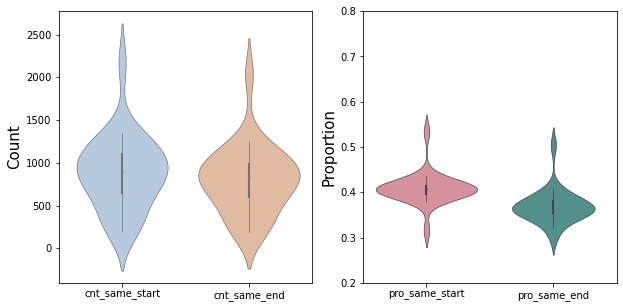

In [89]:
df_cnt, df_pro=count_samePos(whole_gene_file)

In [ ]:
# Now, plan to properly collapse the gene_df.iloc

In [91]:
gene_df.iloc[:100]

,chromosome,TxStart,TxEnd,name
1463,chr1,11873,14409,NR_046018
1460,chr1,14361,29370,NR_024540
1458,chr1,17368,17436,NR_106918
1455,chr1,17368,17436,NR_128720
1457,chr1,17368,17436,NR_107062
...,...,...,...,...
1548,chr1,1334909,1337426,NR_015434
1547,chr1,1337275,1342693,NM_017971
1544,chr1,1353799,1356824,NM_001145210
1545,chr1,1353799,1356824,NM_001243536


In [95]:
# test using this strip
test_df=gene_df[["chromosome","TxStart","TxEnd"]].iloc[:100]

In [96]:
test_df["TxStart"].iloc[0]

11873

In [110]:
len(test_df)

100

In [150]:
len(g_df_chr_lst[0])

5255

In [337]:
def removeOverlapDF(test_df):    
    new_lst=[]
    for i in range(len(test_df)):
        start=test_df["TxStart"].iloc[i]
        end=test_df["TxEnd"].iloc[i]

        exist_pair=(start,end)

        if i==0:
            new_pair=exist_pair
            new_lst.append(new_pair)        
        else:
            start_pre=test_df["TxStart"].iloc[i-1]
            end_pre=test_df["TxEnd"].iloc[i-1]

            # first, concatenate all the shared start
            if start==start_pre:
                new_end=max(end, end_pre)
                new_pair=(start, new_end)
            # second, concatenate all the shared end
            elif end==end_pre:
                new_start=min(start, start_pre)
                new_pair=(new_start, end)
            else:    
                new_pair=exist_pair

        new_lst.append(new_pair) 
    new_lst=list(dict.fromkeys(new_lst))
    
    mod_lst=[[start, end] for (start, end) in new_lst] # as a list element

    for j, elm in enumerate(mod_lst):
        start, end = elm[0], elm[1]

        if j==0:
            continue
        else:
            start_pre=mod_lst[j-1][0]
            end_pre=mod_lst[j-1][1]

            if end_pre>=end:
                mod_lst[j][0]=mod_lst[j-1][0]  # if end_pre is larger than end, replace start as start_pre
                mod_lst[j][1]=mod_lst[j-1][1]  # if end_pre is larger than end, replace end as end_pre

            elif start <=end_pre:
                mod_lst[j][0]=mod_lst[j-1][0]  # current start=start_pre
                mod_lst[j-1][1]=max(mod_lst[j][1],mod_lst[j-1][1])  # end_pre = end

            else:
                continue
           
    mod_lst=[tuple(elm) for elm in mod_lst]
    fin_lst=list(dict.fromkeys(mod_lst))
    gene_collapsed_df=pd.DataFrame(fin_lst, columns=["TxStart", "TxEnd"])
 
    return gene_collapsed_df

In [343]:
def gene_removeDupl(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=[]
    for chr_no in tqdm_notebook(range(len(g_df_chr_lst))):
        gene_df=g_df_chr_lst[chr_no]
        gene_collapsed_df=removeOverlapDF(gene_df)
        new_gene_lst_all.append(gene_collapsed_df)
    return new_gene_lst_all # list of chromosome-wise dataframe for collapsed gene table

In [344]:
new_gene_lst_all= gene_removeDupl(whole_gene_file)

In [342]:
new_lst_all[0]

,TxStart,TxEnd
0,11873,29370
1,30365,30503
2,34610,36081
3,69090,70008
4,134772,140566
...,...,...
2183,249104650,249120154
2184,249120575,249120642
2185,249132376,249143716
2186,249144202,249153315


In [97]:
with open("../database/test_chr1gene.txt", "wb") as f:
    pickle.dump(g_df_chr_lst[0],f)

In [ ]:
def compGene2css(whole_gene_file,df):
    g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    css_gene_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)): # it's right, because we scan the gene file from the df. and only get the no.
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    return css_gene_lst_all